In [26]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [27]:
# To avoid OOM errors, setting GPU Memory Consuption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(f"GPU: {gpu}")
    tf.config.experimental.set_memory_growth(gpu, True) # Keeping the use of memory limited to prevent errors

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [28]:
data_dir = '../data/LIS-fingerspelling-dataset'
img_ex = cv2.imread(os.path.join(data_dir, 'a', 'a_FATIMA_9_front.JPG'))
img_ex.shape

(415, 622, 3)

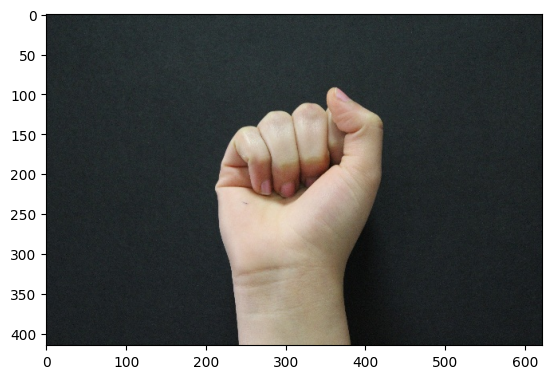

In [29]:
plt.imshow(cv2.cvtColor(img_ex, cv2.COLOR_BGR2RGB))

In [ ]:
# Automatically creates a dataset form the referred directory. Load the full dataset, shuffle = True ensures randomness
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=123
)

# In order to iterare the element we must use the iterative method
data_iterator = dataset.as_numpy_iterator()
data_iterator

Found 6428 files belonging to 22 classes.


NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7fcf78342ec0>)

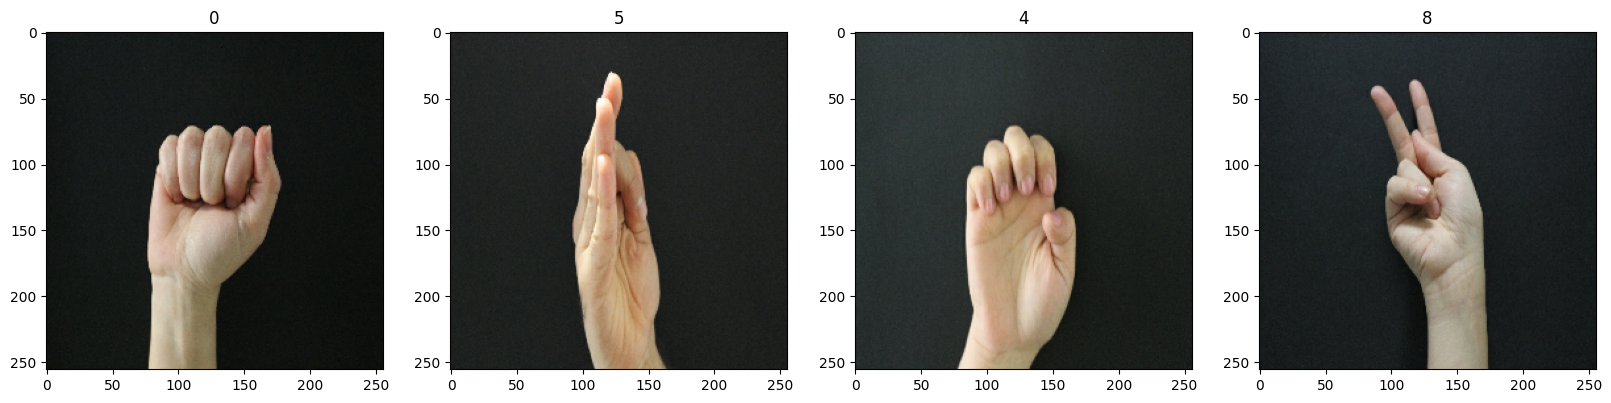

In [31]:
batch = data_iterator.next() # Grabbing a dataset batch

# Exploring a batch labels
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Pre-Processing

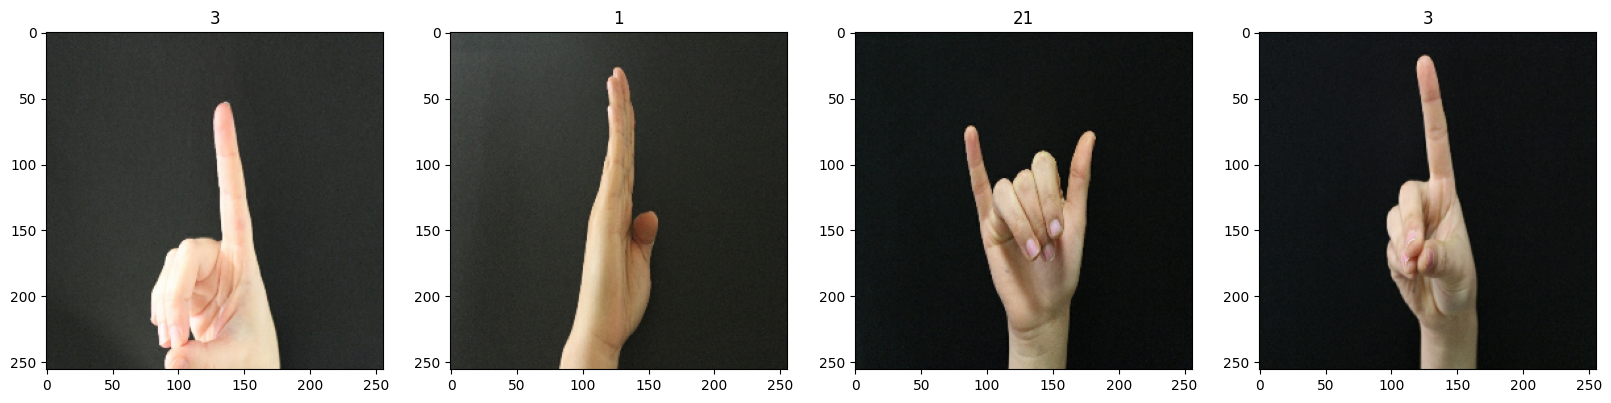

In [ ]:
# Scaling the pixel values in the range [0,1]
scaled_data = dataset.map(lambda x,y: (x/255, y)) # Map method allows the function to be applied as a pipeline, speeding up the calculations

scaled_iterator = scaled_data.as_numpy_iterator()
batch = scaled_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Trainig-Test split

In [ ]:
# Total number of images
dataset_size = dataset.cardinality().numpy()
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = int(0.1 * dataset_size)

# Partition the dataset
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size).take(test_size)

print(f"Batches are divided as follow: {train_size} batches for training, {val_size} for validation, {test_size} for testing")

Batches are divided as follow: 140 batches for training, 40 for validation, 20 for testing


### Building the model

In [35]:
model = Sequential()

# 1st conv block
model.add(Conv2D(16, (3,3), 1 , activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

# 2nd conv block
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# 3rd conv block
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# 4th conv block
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D())

# FNN for the prediction
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(22, activation='softmax'))

/home/acaia/LIS/LIS-Gesture-Translator/.lis/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         5,654 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,525,878 (24.89 MB)

 Trainable params: 6,525,878 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
os.makedirs('../logs', exist_ok=True)
logdir = '../logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # Tracking models performance

history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[tensorboard_callback], verbose=1)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.3017 - loss: 19.1191 - val_accuracy: 0.8188 - val_loss: 0.5902
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7629 - loss: 0.7440 - val_accuracy: 0.9359 - val_loss: 0.2284
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8803 - loss: 0.3793 - val_accuracy: 0.9672 - val_loss: 0.1111
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9289 - loss: 0.2220 - val_accuracy: 0.9750 - val_loss: 0.0885
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9420 - loss: 0.1791 - val_accuracy: 0.9766 - val_loss: 0.0749
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9485 - loss: 0.1606 - val_accuracy: 0.9867 - val_loss: 0.0370
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9631 - loss: 0.1129 - val_accuracy: 0.9758 - val_loss: 0.0801
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9695 - loss: 0.1045 - v

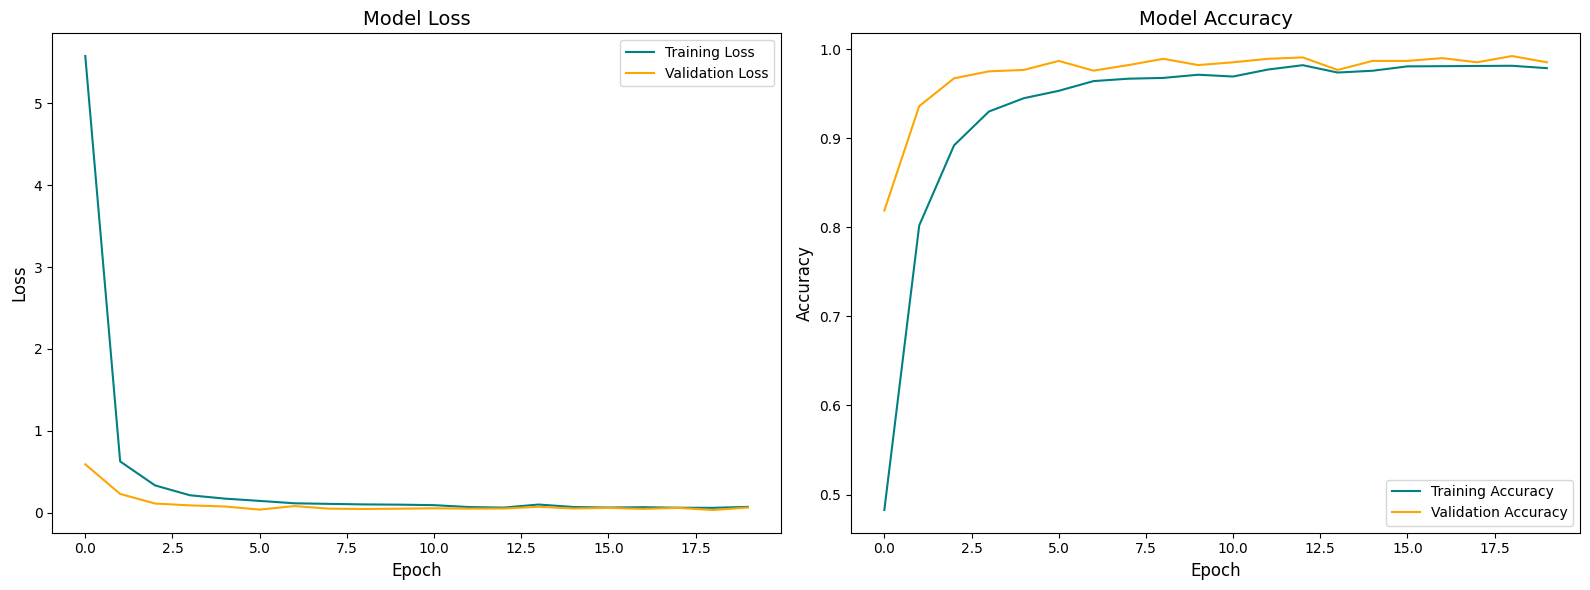

In [38]:
# Plotting training performances
plt.figure(figsize=(16, 6))

# Subplot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='teal', label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')

# Subplot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Model Evaluation

In [ ]:
precision = Precision()
recall = Recall()
accuracy = SparseCategoricalAccuracy()

for batch in test_ds.as_numpy_iterator():
    X, y = batch
    yhat_probs = model.predict(X)              # probs for each class
    yhat_classes = np.argmax(yhat_probs, axis=1)  # class effectivelly predicted

    precision.update_state(y, yhat_classes)
    recall.update_state(y, yhat_classes)
    accuracy.update_state(y, yhat_probs)  # SparseCategoricalAccuracy takes directly probs

print(f"Precision: {precision.result()}\nRecall:{recall.result()}\nAccuracy:{accuracy.result()}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Precision: 1.0
Recall:1.0
Accuracy:0.9828125238418579



In [40]:
model.save(os.path.join('../model', 'multiclass_handsign_v0.h5'))